# Chi Squared Analysis

Chi-squared (χ²) is a statistical test used to determine the association between two categorical variables. It is used to determine whether there is a significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table.

The chi-squared test is often used in hypothesis testing to evaluate the null hypothesis that there is no association between the two variables. The test statistic is calculated as the sum of the squared differences between the observed and expected frequencies, divided by the expected frequencies.

The formula for the chi-squared statistic is:

χ² = ∑(O - E)² / E

where O is the observed frequency, E is the expected frequency, and the sum is taken over all categories.

The chi-squared test produces a p-value, which is the probability of observing a test statistic as extreme as the one calculated, assuming that the null hypothesis is true. A small p-value indicates that the observed frequencies are significantly different from the expected frequencies, and we reject the null hypothesis.

In Python, you can perform a chi-squared test using the scipy.stats module. The scipy.stats.chi2_contingency() function can be used to calculate the chi-squared statistic and the associated p-value for a contingency table.

## Table of Contents
* [Connect to Database ](#Connect-to-database)
* [Import Datasets](#Import-Dataset)
* [Remove Stopwords](#Remove-stopwords)
* [Lemmatization](#Lemmatization)

## Connect to Database

In [72]:
from Functions.connection.connection import *
from Functions.AlertP1.data_cleaning import *
from Functions.AlertP1.features import *
from Functions.analysis.step_analysis import *
from Functions.AlertP1.dummy_features import *
from Functions.Models.Logistic_regression import *
from Functions.Models.evaluation import *
from Data_with_NLP import *

In [73]:
import mysql.connector
import pandas as pd

#creds = ["username","password","juliehaegh","ninG20&19rea","3306"] 
# creds = ["juliehaegh","ninG20&19rea","172.20.20.4","hgo",3306]

creds = pd.read_csv('/Users/gabrielabib/Desktop/NOVA_SBE/PBL/credentials.csv',sep='\t')
creds = creds.Value

In [74]:
#Connection to the database
host = creds[0]
user = creds[1]
password = creds[2]
database = creds[3]
port = creds[4]
mydb = mysql.connector.connect(host=host, user=user, database=database, port=port, password=password, auth_plugin='mysql_native_password')
mycursor = mydb.cursor()

#Safecheck to guarantee that the connection worked
mycursor.execute('SHOW TABLES;')
print(f"Tables: {mycursor.fetchall()}")
print(mydb.connection_id) #it'll give connection_id,if got connected

Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',), ('hgo_data_032023',)]
362


## Import Datasets

In [75]:
# Import Alert P1 dataset
SClinic = pd.read_sql("""SELECT * FROM ConsultaUrgencia_doentespedidosconsultaNeurologia2012""",mydb)

# Import SClinic
AlertP1 = pd.read_sql("""SELECT * FROM consultaneurologia201216anon_true""",mydb)

# Replace all NaN with 0
# AlertP1 = AlertP1.fillna(0)

# Add result column
# AlertP1['result'] = ['Accepted' if x in [0,14,25,20,53,8,12,12] else 'Refused' for x in AlertP1['COD_MOTIVO_RECUSA']]

In [76]:
# Create a new column with accepted and rejected cases
#SClinic['Accepted/Rejected'] = SClinic['COD_MOTIVO_RECUSA'].apply(lambda x: 'Accepted' if x == 0 else 'Rejected')
#SClinic = SClinic[(SClinic['Texto']!='') & (SClinic['Accepted/Rejected']=='Accepted')].iloc[887:987]
#SClinic = SClinic[SClinic['Texto']!='']
#SClinic

In [77]:
#changing columns with date to a datetime
date_format_alertP1(AlertP1)
#change the blank values in proveniencia and priority to unknown
replace_blank(AlertP1)
#merge duplicated entity
entity_duplicated(AlertP1)
#changing the text to lower case
lowering_text(AlertP1)
#create a column with the output of a referral and select the refused and accepted ones
AlertP1=result(AlertP1)

In [78]:
import math

# Split data into train and test
AlertP1_sorted = AlertP1[AlertP1['Texto']!=''].sort_values(by='DATA_RECEPCAO')

# calculate the index for the split
split_index = math.ceil(0.8 * len(AlertP1_sorted))

# split the data frame into test and train sets
train_set = AlertP1_sorted.iloc[:split_index]
test_set = AlertP1_sorted.iloc[split_index:]

In [79]:
# Import librariers 
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from unidecode import unidecode
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings(action="ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Remove Stopwords

In [80]:
# Get rid of special characters and transform Texto column to Latin words
train_set['Texto'] = train_set['Texto'].apply(lambda x: unidecode(x))

#The re.sub function is used to substitute all digits (\d) with an empty string
train_set['Texto'] = train_set['Texto'].apply(lambda x: re.sub(r'\d', '', x))

# Remove all names in Texto variable
# This function uses a regular expression to find all words in the text that start with a 
# capital letter (\b[A-Z][a-z]+\b), which are assumed to be names
text = train_set['Texto'] 

# remove all hyphens from the text
text = text.replace('-', '')

def remove_names(text):
    # Find all words that start with a capital letter
    names = re.findall(r'\b[A-Z][a-z]+\b', text)
    
    # Replace the names with an empty string
    for name in names:
        text = text.replace(name, '')
        
    return text

In [81]:
# Create an empty list to store the text
text_list = []

# Loop through the 'text' column
for text in text.str.lower(): # Transform every word to lower case
    text_list.append(text)

# Print the list of text
#print(text_list)

In [82]:
# Download the Portuguese stop words
nltk.download('stopwords')
nltk.download('punkt')

# Get the Portuguese stop words
stop_words = set(stopwords.words('portuguese'))

# Manually remove stopwords
stop_words.update(['-//','.', ',','(',')',':','-','?','+','/',';','2','1','drª','``','','3','desde','anos','doente','consulta','alterações','se',"''",'cerca','refere','hgo','utente','vossa','s','...','ainda','c','filha','costa','dr.','pereira','ja','--','p','dr','h','n','>','q','//','..','b','++','%','//','-','+++/','=','+++/'])

# Create a new list to store the filtered text
filtered_text = []

# Loop through the text_list and remove the stop words
for text in text_list:
    words = word_tokenize(text)
    words = [word for word in words if word.lower() not in stop_words]
    filtered_text.append(" ".join(words))

# Print the filtered text
#print(filtered_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [83]:
# Save the filtered text as a new column to the dataframe
train_set['filtered_text'] = filtered_text

## Lemmatization

Lemmatization is a text normalization technique used in Natural Language Processing (NLP), that switches any kind of a word to its base root mode. Lemmatization is responsible for grouping different inflected forms of words into the root form, having the same meaning

In [84]:
# Define function for lemmatization
def spacy_lemmatizer(df):
    import spacy
    import pt_core_news_md
    nlp = pt_core_news_md.load()

    doclist = list(nlp.pipe(df))

    docs=[]
    for i, doc in enumerate(doclist):
        docs.append(' '.join([listitem.lemma_ for listitem in doc]))
        
    return docs

In [85]:
# create an empty list to store the words
word_list = []

# loop through each row of the "text_column" column
for index, row in train_set.iterrows():
    
    # split the text into individual words using whitespace as a delimiter
    words = row['filtered_text'].split()
    # add the words to the word list
    word_list.extend(words)

# print the word list
#print(word_list)

In [86]:
# create an empty list to store the words
word_list = []

# loop through each row of the "text_column" column
for index, row in train_set.iterrows():
    
    # split the text into individual words using whitespace as a delimiter
    words = row['filtered_text'].split()
    
    # remove hyphens from the words and add them to the word list
    word_list.extend([word.replace('-', ' ') for word in words])
    # remove slash from the words and ass them to the list
    word_list.extend([word.replace('/', ' ') for word in words])
    # remove slash from the words and ass them to the list
    word_list.extend([word.replace('\-', ' ') for word in words])
    # remove slash from the words and ass them to the list
    word_list.extend([word.replace('\.', ' ') for word in words])
    # remove slash from the words and ass them to the list
    word_list.extend([word.replace('*', ' ') for word in words])
    

# print the cleaned word list
#print(word_list)

In [87]:
Lemma = spacy_lemmatizer(word_list) # Call lemmatizer function

# print length of word_list and compare the count after doing lemmatization
from collections import Counter

items = Counter(Lemma).keys()
print('The number of words after lemmatization:',len(items))

items2 = Counter(word_list).keys()
print('The number of words before lemmatization:',len(items2))

The number of words after lemmatization: 8157
The number of words before lemmatization: 10147


In [88]:
# apply the spacy_lemmatizer function to each row in the 'text' column
train_set['text_lemmatized'] = spacy_lemmatizer(train_set['filtered_text'])

# drop rows with empty strings
train_set_filtered = train_set[['text_lemmatized','filtered_text']].replace('', pd.NA).dropna()
train_set_filtered = pd.DataFrame(train_set_filtered)
train_set_filtered

,text_lemmatized,filtered_text
630,idade tremor acentuar membro alto agravamento ...,idade tremor acentuado membros superiores agra...
752,pe pendente instalacao ha mês atrofiar muscula...,pe pendente instalacao ha meses atrofia muscul...
938,sintomatologia ap diabete tipo hta vir acompan...,sintomatologia ap diabetes tipo hta vem acompa...
1537,relatorio clinico,relatorio clinico
985,trazer inumero relatorio ida hgo-su vulvo-vagi...,traz inumeros relatorios idas hgo-su vulvo-vag...
...,...,...
15,homem provavel demencia vascular agravamento p...,homem provavel demencia vascular agravamento p...
1498,problema saude resolver demencia se enil / alz...,problema saude resolver demencia senil/alzheim...
244,antecedente epilepsia + ultimo ano crise frequ...,antecedentes epilepsia +ultimo ano crises freq...
1118,mulher idade diagnosticos dislipidemia hipertr...,mulher idade diagnosticos dislipidemia hipertr...


In [89]:
len(set(Lemma))

8157

In [90]:
# # create an empty list to store the words
# word_list = []

# # loop through each row of the "text_column" column
# for index, row in train_set.iterrows():
    
#     # split the text into individual words using whitespace as a delimiter
#     words = row['text_lemmatized'].split()
    
#     # remove slash from the words and ass them to the list
#     word_list.extend([word.replace('\.', '') for word in words])
#     # remove slash from the words and ass them to the list
#     word_list.extend([word.replace('\-', '') for word in words])
#     # remove hyphens from the words and add them to the word list
#     word_list.extend([word.replace('-', '') for word in words])
#     # remove slash from the words and ass them to the list
#     word_list.extend([word.replace('/', '') for word in words])
    

# # print the cleaned word list
# print(word_list)

In [91]:
unique_words = list(set(Lemma))
# unique_words.remove('')
len(unique_words)

8157

In [92]:
original_columns = list(train_set.columns)

In [93]:
def word_dummy(df, column,list):
    # list = ["cefaleia","demência","convulsão", "epilepsia", "sincope", "vertigem", "tremor", "acidente vascular cerebral"]
    for d in list:
        df[d] = df[column].str.contains(d)
        df[d] = df[d].astype(int)
    return df

In [94]:
unique_words = [re.escape(word) for word in unique_words]
dataframe = train_set.copy()
word_dummy(dataframe,'text_lemmatized',unique_words)
dataframe.result

630     1
752     1
938     1
1537    0
985     1
       ..
15      0
1498    1
244     0
1118    1
1765    1
Name: result, Length: 1288, dtype: object

In [95]:
import pandas as pd
from scipy.stats import chi2_contingency

original_result = original_columns.remove('result')

dataset = dataframe.drop(original_columns,axis=1)# Features
dataset['result'] = dataset['result'].replace({'accepted': 1, 'refused': 0})

dataset_columns = list(dataset.columns)
# dataset_columns = dataset_columns.remove('result')


chi_test = pd.DataFrame(columns=['word', 'chi2_stats', 'p_value'])

for i in dataset_columns:
    
    # Create the contingency table
    contingency_table = pd.crosstab(index=dataset['result'], columns=dataset[i])
    # Perform the chi-squared test and print the results
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_test = chi_test.append({'word': i, 'chi2_stats': chi2, 'p_value': p}, ignore_index=True)

    # print(f"Chi-squared test statistic: {chi2}")
    # print(f"P-value: {p}")

print(chi_test)


                    word   chi2_stats        p_value
0                 result  1283.327357  4.747215e-281
1           extra\-axial     0.043419   8.349390e-01
2     lenticulo\-capsulo     0.000000   1.000000e+00
3                  senis     0.000000   1.000000e+00
4               preferir     0.033482   8.548130e-01
...                  ...          ...            ...
8153    espaco\ temporal     0.000000   1.000000e+00
8154          cortico\-r     0.000000   1.000000e+00
8155        semanalmente     0.000000   1.000000e+00
8156       craneo\.fazer     0.000000   1.000000e+00
8157           ateracoes     0.288049   5.914732e-01

[8158 rows x 3 columns]


In [96]:
chi_test.sort_values(by=['chi2_stats'], inplace=True, ascending=False)
chi_test

,word,chi2_stats,p_value
0,result,1283.327357,4.747215e-281
385,relatorio,234.326968,6.787975e-53
5187,relato,228.171959,1.492844e-51
5306,s,177.733586,1.514563e-40
3550,p,174.995167,6.001530e-40
...,...,...,...
4804,foto\ /\ fonofobia,0.000000,1.000000e+00
2325,buscalma,0.000000,1.000000e+00
2327,revascularizacaar,0.000000,1.000000e+00
4799,diu\-cu,0.000000,1.000000e+00


In [97]:
def log_regression(features,target):
    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,random_state=16,shuffle=False)
    # instantiate the model (using the default parameters)
    logreg = LogisticRegression(random_state=16)
    # fit the model with data
    clf=logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    return y_pred,clf.coef_, clf.intercept_,X_train, X_test, y_train, y_test

In [98]:
chi_test['word_length'] = chi_test['word'].str.len()
chi_test

,word,chi2_stats,p_value,word_length
0,result,1283.327357,4.747215e-281,6
385,relatorio,234.326968,6.787975e-53,9
5187,relato,228.171959,1.492844e-51,6
5306,s,177.733586,1.514563e-40,1
3550,p,174.995167,6.001530e-40,1
...,...,...,...,...
4804,foto\ /\ fonofobia,0.000000,1.000000e+00,18
2325,buscalma,0.000000,1.000000e+00,8
2327,revascularizacaar,0.000000,1.000000e+00,17
4799,diu\-cu,0.000000,1.000000e+00,7


In [99]:
AlertP1 = dataframe.copy()
AlertP1=bef_accepted(AlertP1)
class_area(AlertP1)
text_length(AlertP1)
referral_steps(AlertP1)
speciality(AlertP1)
AlertP1=unit(AlertP1)

In [100]:
AlertP1 = AlertP1.sort_values('DATA_RECEPCAO')
data = structured_data_dummies(AlertP1)
print(data.columns)
data=data[data['text_length']>0]
data

Index([          'ID_DOENTE',            'PROCESSO',      'COD_REFERENCIA',
                    'COD_PZ', 'COD_UNID_SAUDE_PROV',           'UNID_PROV',
                 'TIPO_UNID',       'COD_CTH_PRIOR',           'CTH_PRIOR',
         'COD_MOTIVO_RECUSA',
       ...
                   'unknown',  'Other specialities',                     2,
                        '3+',                'HOSP',                'UCSP',
                     'USF A',               'USF B',               'outro',
       'not accepted before'],
      dtype='object', length=8204)


,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,COD_CTH_PRIOR,CTH_PRIOR,COD_MOTIVO_RECUSA,...,unknown,Other specialities,2,3+,HOSP,UCSP,USF A,USF B,outro,not accepted before
630,EGBZZB,VLNMEEM,LOHHHSHT,SSDBHEA,3150502,CHARNECA DA CAPARICA,CS/USF,,unknown,0,...,0,0,0,0,0,0,1,0,0,1
1103,ESSSBD,LLDDNEN,LOHHLTSH,SCCBZCA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,0,...,0,1,0,0,0,0,0,1,0,1
752,DECZCS,VLEVCVE,LOHHLTOU,SCCDEGG,3151672,USF AMORA SAUDAVEL,CS/USF,,unknown,0,...,0,0,0,0,0,0,0,1,0,1
1537,FGSEDD,MIVCNDB,LOHHLSTU,,0,,OUTRA,,unknown,7,...,1,0,0,0,0,0,0,0,0,1
985,BSEZF,LLCBVJI,LOHHLTRS,SCCABHA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,53,...,0,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,SSEZDD,LVNEBL,LSHHLVPH,,0,,OUTRA,,unknown,10,...,0,0,0,0,0,0,0,0,0,1
244,SADASC,LLBIJL,LSHHOORU,ZZAHSEGG,3151575,USF TORRE DA MARINHA,CS/USF,,unknown,7,...,0,0,1,0,0,0,0,1,0,0
1498,EFFBDE,MIVNMJC,LSHHORLP,ZZAZZEFD,3150671,USF COVA DA PIEDADE-CS C PIEDA,CS/USF,3,Normal,0,...,0,0,0,0,0,0,0,1,0,1
1118,DAEZZB,LLDBNMJ,LSHHOUSS,ZZAZGHSB,3150502,CHARNECA DA CAPARICA,CS/USF,3,Normal,0,...,0,0,0,0,0,0,1,0,0,1


In [101]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text']
all_columns = list(data.columns)

for i in eliminate_cols:
    all_columns.remove(i)

print(all_columns)

X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable

X


['filtered_text', 'text_lemmatized', 'extra\\-axial', 'lenticulo\\-capsulo', 'senis', 'preferir', 'refractario', 'vita', 'ganglio', 'e\\.c\\.g', '\\+\\ ostriormente', 'zometar', 'prodromico', 'ruptura', 'levantar\\ se', 'pai\\+', 'supra\\ tentorial', 'retinianas', 'canado', 'Back', 'emagrecimento', 'cadeira', 'acontecimento', 'cerebelosoe', 'fibromialgico', 'sub', 'fumador', 'operac', 'tiroide', 'diferenciacao', 'l\\ s', 'abstinecer', 'laboral', 'frequentes\\.marcha', 'Bunil', 'contraceptivo', 'Cefaleiass', 'sulco\\ cisternal', 'cefe', 'sg', 'ponho', 'auge', 'nervoso', 'paterna', 'espondilodiscartrose', '\\+\\ vomito', 'espasmo', 'voce', 'foraminal', 'irriatcao', 'estabelecer', '\\+', 'partic', 'sedativo', 'pseudodemencia', 'mimica', 'melhoria\\.realizar', 'corticais\\.colocar\\ se', 'Mairo', 'tsh\\ \\.', 'tansulosinar', 'convulcoes\\ /\\ incontinencia', 'monofasico', 'mal\\ definir', 'hsjose', 'estudante', 'ingestao', 'corneto', 'provocar', 'professora', '/', 'fenobarbital', 'hemisfer

,filtered_text,text_lemmatized,extra\-axial,lenticulo\-capsulo,senis,preferir,refractario,vita,ganglio,e\.c\.g,...,unknown,Other specialities,2,3+,HOSP,UCSP,USF A,USF B,outro,not accepted before
630,idade tremor acentuado membros superiores agra...,idade tremor acentuar membro alto agravamento ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1103,tremor fino ambas maos boca ha meses deixa cai...,tremor fino ambos mao bocar ha mês deixar cair...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
752,pe pendente instalacao ha meses atrofia muscul...,pe pendente instalacao ha mês atrofiar muscula...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1537,relatorio clinico,relatorio clinico,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
985,traz inumeros relatorios idas hgo-su vulvo-vag...,trazer inumero relatorio ida hgo-su vulvo-vagi...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,homem provavel demencia vascular agravamento p...,homem provavel demencia vascular agravamento p...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
244,antecedentes epilepsia +ultimo ano crises freq...,antecedente epilepsia + ultimo ano crise frequ...,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1498,problema saude resolver demencia senil/alzheim...,problema saude resolver demencia se enil / alz...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1118,mulher idade diagnosticos dislipidemia hipertr...,mulher idade diagnosticos dislipidemia hipertr...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [118]:
#split dataset in features and target variable// Question: is it the right option?


# assuming your data is stored in a DataFrame object called 'data'
data.columns = data.columns.astype(str)

eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text','filtered_text','text_lemmatized']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable


features=X.columns
#log_regression is defined in functions
y_pred,coefficients,intercept,X_train, X_test, y_train, y_test=log_regression(X,y)
df = pd.DataFrame(features, columns =['Feature'])
df['coefficients']=coefficients.T
df


,Feature,coefficients
0,extra\-axial,-0.040060
1,lenticulo\-capsulo,-0.069351
2,senis,0.046843
3,preferir,0.022131
4,refractario,0.000000
...,...,...
8165,UCSP,0.387893
8166,USF A,-0.435951
8167,USF B,0.640864
8168,outro,0.216995


In [119]:
y_df = pd.DataFrame(y_test)
distribution = y_df.value_counts()
distribution

result
1         169
0          89
dtype: int64

Accuracy: 0.73
Recall: 0.85
Precision: 0.77
              precision    recall  f1-score   support

     refused       0.64      0.51      0.57        89
    accepted       0.77      0.85      0.81       169

    accuracy                           0.73       258
   macro avg       0.70      0.68      0.69       258
weighted avg       0.72      0.73      0.72       258



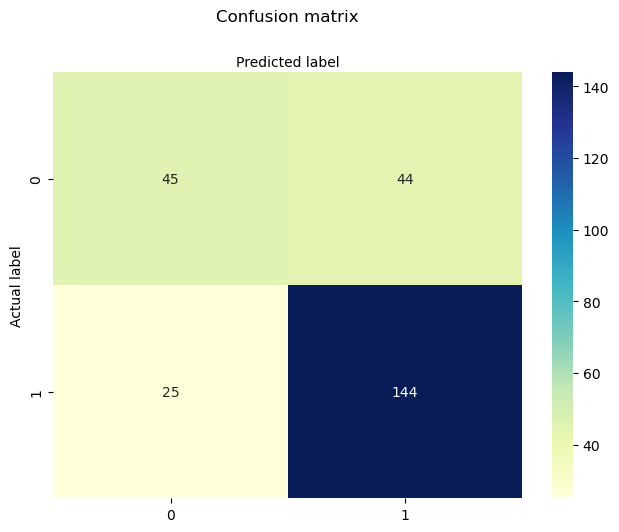

In [120]:
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
# Evaluate the recall of the model
recall = recall_score(y_test, y_pred)
print("Recall: {:.2f}".format(recall))

# Evaluate the precision of the model
precision = precision_score(y_test, y_pred)
print("Precision: {:.2f}".format(precision))

# Calculate the confusion matrix of the model
cnf_matrix = confusion_matrix(y_test, y_pred)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# Print the evaluation matrix
target_names = ['refused', 'accepted']
print(classification_report(y_test, y_pred, target_names=target_names))

In [121]:
p_values = p_value(X,y)
p_values.sort_values(by=['p_value'], inplace=True, ascending=False)
p_values

,Feature,p_value
5209,aine,0.986942
4796,repeticao,0.986942
4364,cumprir,0.986942
663,\-dez\-,0.986942
5738,zon,0.986942
...,...,...
8133,distribuir\ se,NaN
8136,malformacoes,NaN
8151,espaco\ temporal,NaN
8152,cortico\-r,NaN


## Calculate distance between words using 'Jarowynkler'

In natural language processing and text mining, the distance between words refers to the measure of how dissimilar or different two words are in terms of their spelling, meaning, or context. It is used to compare two words or to quantify the similarity between them.

These distance metrics are useful in many natural language processing tasks, such as spell checking, text classification, clustering, and information retrieval, among others. They enable us to quantify the similarity or dissimilarity between words or texts and to make data-driven decisions based on this information.

In the code below, we will just measure the distance between medication words.

In [106]:
# # Import medication list
# drug_name = pd.read_excel('/Users/juliehaegh/Downloads/drugs_data.xlsx')

# # Convert string to list
# drug_list = drug_name.drug_name.values.tolist()

In [107]:
import Levenshtein

# create an empty list to store the distances
distances = []

# loop through each pair of adjacent words in the word list
for i in range(len(word_list)-1):
    
    # calculate the Levenshtein distance between the current word and the next word
    distance = Levenshtein.distance(word_list[i], word_list[i+1])
    
    # add the distance to the list of distances
    distances.append(distance)

# print the list of distances
#print(len(distances))
#print(distances)

In [108]:
import Levenshtein

# create an empty list to store the distances
distances = []

# loop through each pair of adjacent words in the word list
for i in range(len(word_list)-1):
    
    # calculate the Levenshtein distance between the current word and the next word
    distance = Levenshtein.distance(word_list[i], word_list[i+1])
    
    # add the distance to the list of distances
    distances.append(distance)

# merge adjacent words with a distance lower than 1
merged_word_list = []
i = 0
while i < len(word_list):
    if i == len(word_list) - 1:
        # last word in the list, add it to the merged word list
        merged_word_list.append(word_list[i])
        i += 1
    elif distances[i] < 1:
        # merge the current and next word into a single word and add it to the merged word list
        merged_word_list.append(word_list[i] + word_list[i+1])
        i += 2
    else:
        # add the current word to the merged word list
        merged_word_list.append(word_list[i])
        i += 1

# print the merged word list
#print(merged_word_list)

In [109]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# create a CountVectorizer object
count_vectorizer = CountVectorizer()

# fit and transform the text data
count_matrix = count_vectorizer.fit_transform(train_set_filtered['text_lemmatized'])

# create a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer()

# fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(train_set_filtered['text_lemmatized'])

# print the document-term matrix for CountVectorizer
#print("Count Vectorizer:\n")
#print(pd.DataFrame(count_matrix.toarray(), columns=count_vectorizer.get_feature_names_out()))

# print the document-term matrix for TfidfVectorizer
#print("\nTF-IDF Vectorizer:\n")
#print(pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out()))

In [110]:
# create a CountVectorizer object
count_vectorizer = CountVectorizer()

# fit and transform the text data
#count_matrix = count_vectorizer.fit_transform(train_set_filtered['text_lemmatized'])
count_matrix = count_vectorizer.fit_transform(train_set['text_lemmatized'])

# create a dataframe for CountVectorizer output
count_df = pd.DataFrame(count_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())

# create a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer()

# fit and transform the text data
#tfidf_matrix = tfidf_vectorizer.fit_transform(train_set_filtered['text_lemmatized'])
tfidf_matrix = tfidf_vectorizer.fit_transform(train_set['text_lemmatized'])

# create a dataframe for TfidfVectorizer output
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# print the document-term matrix for CountVectorizer
print("Count Vectorizer:\n")
count_df

# print the document-term matrix for TfidfVectorizer
print("\nTF-IDF Vectorizer:\n")
tfidf_df
tfidf_df.to_csv('tf-idf.csv')

Count Vectorizer:


TF-IDF Vectorizer:



In [111]:
tf_idf = tfidf_df.max().sort_values(ascending=False).head(100)
#tf_idf.to_csv('tf-idf.csv')
#mean_scores = tfidf_df.mean()
#mean_scores.sort_values(ascending=False).head(20)

In [112]:
# Load tf-idf scores
tfidf_data = pd.read_csv('tf-idf.csv')
tfidf_data

,Unnamed: 0,aa,aas,abaixo,abandonar,abandono,abcesso,abd,abdominal,abducaor,...,zomig,zon,zona,zonegran,zoster,zumbido,zumbir,zyloric,zyprexa,zyprexo
0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,1283,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1284,1284,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1285,1285,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1286,1286,0.0,0.079989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
# Replace all NaN with 0
tfidf_data = tfidf_data.fillna(0)
#tfidf_data

Next, concatenate the SClinic dataset with the tfidf_data dataframe using the concat() function from the pandas library.

In [114]:
AlertP1_tfidf = pd.concat([train_set, tfidf_data], axis=1)

# Check for NaN values in a DataFrame called my_data
print(AlertP1_tfidf.isnull().sum())

# Remove NaN values from my_data
AlertP1_tfidf.dropna(inplace=True)

# Replace NaN values with 0 in my_data
AlertP1_tfidf.fillna(0, inplace=True)

ID_DOENTE              361
PROCESSO               361
COD_REFERENCIA         361
COD_PZ                 361
COD_UNID_SAUDE_PROV    361
                      ... 
zumbido                361
zumbir                 361
zyloric                361
zyprexa                361
zyprexo                361
Length: 7606, dtype: int64


In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def log_regression(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    coefficients = log_reg.coef_
    intercept = log_reg.intercept_
    return y_pred, coefficients, intercept, X_train, X_test, y_train, y_test

In [116]:
from sklearn.linear_model import LogisticRegression

eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','text_lemmatized','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','filtered_text','Texto','PROVENIENCIA']
X = AlertP1_tfidf.drop(eliminate_cols,axis=1)# Features
y = AlertP1_tfidf['result']

# Instantiate the LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Fit the encoder on the target variable and transform it
y = le.fit_transform(y)
features=X.columns

log_reg = LogisticRegression()
log_reg.fit(X, y)

#log_regression is defined in functions
y_pred,coefficients,intercept,X_train, X_test, y_train, y_test=log_regression(X,y)
df = pd.DataFrame(features, columns =['Feature'])
df['coefficients']=coefficients.T
df.sort_values(by= 'coefficients',ascending=False).head(20)

ValueError: could not convert string to float: 'doente de 71 anos de idade, com tremor acentuado dos membros superiores, com agravamento no último ano, interferindo com a realização das actividades de vida diária e com a condução (tem filho com esquizofrenia que já não consegue levar a instituição onde passava o dia, por dificuldades na condução).'

Accuracy: 0.6533333333333333
Recall: 0.038461538461538464
Precision: 0.5
              precision    recall  f1-score   support

     refused       0.66      0.98      0.79       147
    accepted       0.50      0.04      0.07        78

    accuracy                           0.65       225
   macro avg       0.58      0.51      0.43       225
weighted avg       0.60      0.65      0.54       225



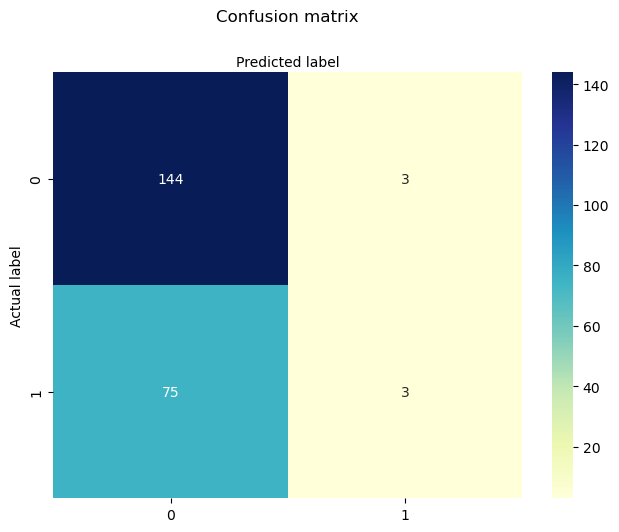

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the recall of the model
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Evaluate the precision of the model
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate the confusion matrix of the model
cnf_matrix = confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# Print the evaluation matrix
target_names = ['refused', 'accepted']
print(classification_report(y_test, y_pred, target_names=target_names))

# 